In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import nengolib
import numpy as np
import pandas as pd
import random
import scipy as sp

import pytry

In [2]:
from sklearn.decomposition import PCA

class PatternInterpolationTrial(pytry.Trial):
    def params(self):
        self.param('number of neurons', n_neurons=2000),
        self.param('number of training patterns', n_train_pattern=3)
        
    def evaluate(self, q):
        data = pd.read_csv("pinsoro-2017-06-12-140651300755-small.csv", low_memory=False)
        
        x = np.array(data.iloc[:,11:195]).astype(float)
        a = []
        for i in range(x.shape[1]):
            y = pd.Series(x[:,i])
            z = y.interpolate(limit_direction='both')
            a.append(z)
        a = pd.DataFrame(a)
        a = a.dropna()
        a = np.array(a).T

        dt = 0.001
        
        def extract_pattern(start, end):
            pattern = np.array(a[start:end,:]).astype(float)
            frames = np.array(data.iloc[start:end,9]).astype(int)

            good_indices = frames != -1
            frames = frames[good_indices]
            pattern = pattern[good_indices]

            fps = 30.0
            t_sample = (frames - frames[0])/fps

            t = np.arange(int(t_sample[-1]/dt))*dt

            result = []
            for i in range(pattern.shape[1]):       
                p = np.interp(t, t_sample, pattern[:,i])
                result.append(p)
            result = np.array(result).T

            return t, result


        t1, result1 = extract_pattern(10175, 10280) #goaloriented
        t2, result2 = extract_pattern(13811, 14182) #goaloriented
        t3, result3 = extract_pattern(22753, 22853) #goaloriented
        t4, result4 = extract_pattern(8991, 9357) #goaloriented
        t5, result5 = extract_pattern(6375, 6762) #goaloriented

        t6, result6 = extract_pattern(22854, 23059) #noplay
        t7, result7 = extract_pattern(9796, 10174) #noplay 
        t8, result8 = extract_pattern(14583, 14991) #noplay
        t9, result9 = extract_pattern(9358, 9696) #noplay 
        t10, result10 = extract_pattern(6763, 6926) #noplay

        goal_list = [result1, result2, result3, result4, result5]
        noplay_list = [result6, result7, result8, result9, result10]
        
        n_train_pattern=q.n_train_pattern
        
        goal_list1 = random.sample(goal_list, n_train_pattern)
        noplay_list1 = random.sample(noplay_list, n_train_pattern)
        train_all = np.vstack(goal_list1+noplay_list1)
        pca_model = PCA(n_components=1).fit(train_all)

        goal_patterns = {}
        i=0
        for p in goal_list1:
            goal_patterns[i] = pca_model.transform(p)[:,0]
            i+=1

        noplay_patterns = {}
        for p in noplay_list1:
            noplay_patterns[i] = pca_model.transform(p)[:,0]
            i+=1

        patterns = {}
        patterns.update(goal_patterns)
        patterns.update(noplay_patterns)

        goal_patterns = [(goal_patterns[key]) for key in goal_patterns.keys()]
        noplay_patterns = [(noplay_patterns[key]) for key in noplay_patterns.keys()] 

        theta = 1.0
        net = nengo.Network()
        with net:
            process = nengo.processes.WhiteSignal(period=100., high=1.0, y0=0)
            rw = nengolib.networks.RollingWindow(theta=theta, n_neurons=q.n_neurons, process=process, neuron_type=nengo.LIFRate(tau_rc=0.02, tau_ref=0.002, amplitude=1))
            
        s_window = int(theta/dt)
        s_pattern = len(min(patterns.values(), key=len))


        t_window = np.linspace(0, 1, s_window)
        inv_basis = rw.inverse_basis(t_window)

        eval_points=[]
        target = []
        for i in range(s_pattern):
            for p in goal_patterns:
                eval_points.append(np.dot(inv_basis, np.roll(p, i)[:s_window]))
                target.append([1])
            for p in noplay_patterns:
                eval_points.append(np.dot(inv_basis, np.roll(p, i)[:s_window]))
                target.append([-1])

        eval_points = np.array(eval_points)
        
        with net:
            result = nengo.Node(None, size_in=1)
            nengo.Connection(rw.state, result,
                             eval_points=eval_points, scale_eval_points=True,
                             function=target, synapse=0.1)

#EXTRACT TEST PATTERNS
        t11, result11 = extract_pattern(8684, 8990) #aimless
        t12, result12 = extract_pattern(10464, 10822) #aimless
        t13, result13 = extract_pattern(13062, 13810) #aimless

        testp1 = pca_model.transform(result11)[:,0]
        testp2 = pca_model.transform(result12)[:,0]
        testp3 = pca_model.transform(result13)[:,0]
       
        goalp = goal_patterns[0]
        aimp = testp1
        noplayp = noplay_patterns[0]
        
        p_all = np.hstack([goalp, aimp, noplayp])

        presentation_time_test=30/len(p_all)

        model = nengo.Network()
        model.networks.append(net)
        with model:    
            stim = nengo.Node(nengo.processes.PresentInput(p_all, presentation_time=presentation_time_test))
            nengo.Connection(stim, rw.input, synapse=None)

            p_result = nengo.Probe(result)
            p_stim = nengo.Probe(stim)
        sim = nengo.Simulator(model)
        sim.run(30)

        #plt.plot(sim.trange(), sim.data[p_stim], label='input')
        #plt.plot(sim.trange(), sim.data[p_result], label='output')
        #plt.legend(loc='best')



        goalp_len = int(len(goalp)*presentation_time_test/dt)
        aimp_len = goalp_len+int(len(aimp)*presentation_time_test/dt)
        noplayp_len = aimp_len+int(len(noplayp)*presentation_time_test/dt)

        mean1 = np.mean(sim.data[p_result][0:goalp_len])
        std1 = np.std(sim.data[p_result][0:goalp_len])
        median1 = np.median(sim.data[p_result][0:goalp_len])

        mean2 = np.mean(sim.data[p_result][goalp_len:aimp_len])
        std2 = np.std(sim.data[p_result][goalp_len:aimp_len])
        median2 = np.median(sim.data[p_result][goalp_len:aimp_len])

        mean3 = np.mean(sim.data[p_result][aimp_len:noplayp_len])
        std3 = np.std(sim.data[p_result][aimp_len:noplayp_len])
        median3 = np.median(sim.data[p_result][aimp_len:noplayp_len])

        #print("Goal Oriented Mean:   ",mean1," SD: ",std1," Median: ",median1)
        #print("Aimless Mean:         ",mean2," SD: ",std2," Median: ",median2)
        #print("No Play Mean:         ",mean3," SD: ",std3," Median: ",median3)
        
        
        return dict(
            mean_goal=mean1,
            std_goal=std1,
            median_goal=median1,
            mean_aimless=mean2,
            std_aimless=std2,
            median_aimless=median2,
            mean_noplay=mean3,
            std_noplay=std3,
            median_noplay=median3,
        )


In [3]:
PatternInterpolationTrial().run(n_train_pattern=2, data_dir='debug')

running PatternInterpolationTrial#20190124-202026-3ca78c59


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 2000
n_train_pattern = 2
mean_aimless = 0.5814481586462095
mean_goal = 0.6435232073511201
mean_noplay = -0.7339026599098218
median_aimless = 0.7156698834893229
median_goal = 0.841682545661629
median_noplay = -0.992170074292924
std_aimless = 0.5890720117215307
std_goal = 0.5695026669590342
std_noplay = 0.49833550545294447


{'mean_goal': 0.6435232073511201,
 'std_goal': 0.5695026669590342,
 'median_goal': 0.841682545661629,
 'mean_aimless': 0.5814481586462095,
 'std_aimless': 0.5890720117215307,
 'median_aimless': 0.7156698834893229,
 'mean_noplay': -0.7339026599098218,
 'std_noplay': 0.49833550545294447,
 'median_noplay': -0.992170074292924}

In [4]:
for seed in range(5):
    for n_neurons in [200, 500, 1000, 2000, 5000]:
        PatternInterpolationTrial().run(seed=seed, n_neurons=n_neurons,
                                        data_dir='vary_n_neurons')


running PatternInterpolationTrial#20190124-202104-e0fb6a0f


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 200
n_train_pattern = 3
mean_aimless = 0.5149524301756754
mean_goal = 0.4663403760409894
mean_noplay = -0.0640561438979312
median_aimless = 0.5985720978238956
median_goal = 0.535325658263254
median_noplay = -0.38316380996107996
std_aimless = 0.38924740858617446
std_goal = 0.4725247307881388
std_noplay = 0.5721849931121429
running PatternInterpolationTrial#20190124-202135-30c903d3


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 500
n_train_pattern = 3
mean_aimless = 0.6923583710886637
mean_goal = 0.5645783441257983
mean_noplay = -0.10547208291775036
median_aimless = 0.8440828784457749
median_goal = 0.7621730773856168
median_noplay = -0.45056820302629813
std_aimless = 0.40915075338196494
std_goal = 0.5476509588478494
std_noplay = 0.6981449504639877
running PatternInterpolationTrial#20190124-202207-771fd10e


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 1000
n_train_pattern = 3
mean_aimless = 0.7667089977121812
mean_goal = 0.6197850307170358
mean_noplay = -0.1045664546286801
median_aimless = 0.9689375667197774
median_goal = 0.7826142134553067
median_noplay = -0.4506034130321853
std_aimless = 0.47184382958281
std_goal = 0.5711322676186544
std_noplay = 0.7338192232815262
running PatternInterpolationTrial#20190124-202240-1951f5bc


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 2000
n_train_pattern = 3
mean_aimless = 0.6754345686581064
mean_goal = 0.5353735457420497
mean_noplay = -0.14223104798383981
median_aimless = 0.7797152704067796
median_goal = 0.7237945003670418
median_noplay = -0.45778362614194434
std_aimless = 0.43884282799403174
std_goal = 0.5630150374661671
std_noplay = 0.7506294245350837
running PatternInterpolationTrial#20190124-202323-675242b4


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 5000
n_train_pattern = 3
mean_aimless = 0.6171813327499136
mean_goal = 0.5185255578786557
mean_noplay = -0.14124040613345581
median_aimless = 0.8049548920098731
median_goal = 0.7458705397269483
median_noplay = -0.45538634618276763
std_aimless = 0.4894942802093584
std_goal = 0.5581467958413742
std_noplay = 0.7532841225835037
running PatternInterpolationTrial#20190124-202430-c17395c0


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 200
n_train_pattern = 3
mean_aimless = 0.6986410754431658
mean_goal = -0.22081875764474265
mean_noplay = -0.6798149829277369
median_aimless = 0.760034484848426
median_goal = -0.13210447150903412
median_noplay = -0.7778934150537813
std_aimless = 0.27531931293924966
std_goal = 0.5458051038081043
std_noplay = 0.4525871756633157
running PatternInterpolationTrial#20190124-202504-896cfb38


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 500
n_train_pattern = 3
mean_aimless = 0.7469537933948853
mean_goal = -0.25910021380840015
mean_noplay = -0.6683193908400739
median_aimless = 0.8394888939096031
median_goal = -0.2601711560898928
median_noplay = -0.7780938735743611
std_aimless = 0.3482276018166248
std_goal = 0.591277764963012
std_noplay = 0.4562450053179147
running PatternInterpolationTrial#20190124-202533-501693b8


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 1000
n_train_pattern = 3
mean_aimless = 0.7705715028972268
mean_goal = -0.2908616690753739
mean_noplay = -0.6856844843014458
median_aimless = 0.893002147314435
median_goal = -0.3135507294715166
median_noplay = -0.8180464980002664
std_aimless = 0.47613331099605
std_goal = 0.6373657880514856
std_noplay = 0.48276586769219415
running PatternInterpolationTrial#20190124-202558-e0c47a3b


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 2000
n_train_pattern = 3
mean_aimless = 0.7486241154369423
mean_goal = -0.3147614652188658
mean_noplay = -0.6901700536734484
median_aimless = 0.8973325807899081
median_goal = -0.39785421036590757
median_noplay = -0.8200218620225067
std_aimless = 0.5367170969870619
std_goal = 0.6415503091605225
std_noplay = 0.4966943247468314
running PatternInterpolationTrial#20190124-202629-b68840fc


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 5000
n_train_pattern = 3
mean_aimless = 0.7324556697083406
mean_goal = -0.24374305860008816
mean_noplay = -0.7278408382053649
median_aimless = 0.8223563825443225
median_goal = -0.24488808194824818
median_noplay = -0.8621520091665741
std_aimless = 0.5217035346212865
std_goal = 0.7567670609691384
std_noplay = 0.5261599610915241
running PatternInterpolationTrial#20190124-202742-b6f8ef5a


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
n_neurons = 200
n_train_pattern = 3
mean_aimless = 0.5388646755651333
mean_goal = 0.35995148358142276
mean_noplay = -0.11342456154421983
median_aimless = 0.6970077604932928
median_goal = 0.5558569938452101
median_noplay = -0.41978571105818013
std_aimless = 0.49860577195728606
std_goal = 0.4218839460028166
std_noplay = 0.6181523231218865
running PatternInterpolationTrial#20190124-202801-06450a08


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
n_neurons = 500
n_train_pattern = 3
mean_aimless = 0.5673557782428057
mean_goal = 0.40125455296021306
mean_noplay = -0.10735650679194363
median_aimless = 0.9903981549147691
median_goal = 0.5970564630289998
median_noplay = -0.5558540026479908
std_aimless = 0.763725367522507
std_goal = 0.4620641338715365
std_noplay = 0.7521479549764634
running PatternInterpolationTrial#20190124-202824-d4ce4c36


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
n_neurons = 1000
n_train_pattern = 3
mean_aimless = 0.3468396745039018
mean_goal = 0.48186976880769855
mean_noplay = -0.1168362257251077
median_aimless = 0.9564336425521438
median_goal = 0.7330584831473637
median_noplay = -0.5928310415037173
std_aimless = 1.0962707560020049
std_goal = 0.5045998534325419
std_noplay = 0.7703197377565729
running PatternInterpolationTrial#20190124-202851-d72b1b18


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
n_neurons = 2000
n_train_pattern = 3
mean_aimless = 0.5044152521279898
mean_goal = 0.5111338629379788
mean_noplay = -0.11021665211871136
median_aimless = 0.9021603095122507
median_goal = 0.7676148844557773
median_noplay = -0.5383294990634683
std_aimless = 1.027340125080931
std_goal = 0.5225532661878124
std_noplay = 0.7705986845362466
running PatternInterpolationTrial#20190124-202926-2a9c1252


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
n_neurons = 5000
n_train_pattern = 3
mean_aimless = 0.3420292374425399
mean_goal = 0.5845335947917452
mean_noplay = -0.1494312364870262
median_aimless = 0.695524216522752
median_goal = 0.8021083775716482
median_noplay = -0.5675054422687007
std_aimless = 0.8832958803828446
std_goal = 0.563118993972425
std_noplay = 0.7903603634941634
running PatternInterpolationTrial#20190124-203030-890fee63


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
n_neurons = 200
n_train_pattern = 3
mean_aimless = 0.09007066186449136
mean_goal = -0.251850826999707
mean_noplay = -0.2668164951289911
median_aimless = 0.17887633763940552
median_goal = -0.14844434703122875
median_noplay = -0.17252482846250372
std_aimless = 0.37080864785565665
std_goal = 0.4523645580608558
std_noplay = 0.36090417922350504
running PatternInterpolationTrial#20190124-203055-c8ba6e46


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
n_neurons = 500
n_train_pattern = 3
mean_aimless = 0.09865077279482264
mean_goal = -0.37206282627596166
mean_noplay = -0.33920815875920884
median_aimless = 0.19939291517831964
median_goal = -0.3806150518796618
median_noplay = -0.3263160177249642
std_aimless = 0.4140840714266387
std_goal = 0.5184354275234018
std_noplay = 0.3484165445914149
running PatternInterpolationTrial#20190124-203122-c1dbd423


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
n_neurons = 1000
n_train_pattern = 3
mean_aimless = 0.15932283402914935
mean_goal = -0.33411390418887377
mean_noplay = -0.3441571411371352
median_aimless = 0.2539590932766933
median_goal = -0.37431034901060606
median_noplay = -0.3227923569890456
std_aimless = 0.49700649781690387
std_goal = 0.5043629034799434
std_noplay = 0.3665357075838028
running PatternInterpolationTrial#20190124-203144-c69dd3f5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
n_neurons = 2000
n_train_pattern = 3
mean_aimless = 0.23667854059646473
mean_goal = -0.36190143450233064
mean_noplay = -0.38288764408333836
median_aimless = 0.33496255489249627
median_goal = -0.4379602476185342
median_noplay = -0.3850077384359891
std_aimless = 0.5693447676020834
std_goal = 0.5322869749797351
std_noplay = 0.36303390363714344
running PatternInterpolationTrial#20190124-203215-1f08f253


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
n_neurons = 5000
n_train_pattern = 3
mean_aimless = 0.3146415738915157
mean_goal = -0.31745017783922747
mean_noplay = -0.3720210858633661
median_aimless = 0.3205487671808726
median_goal = -0.30291001926752886
median_noplay = -0.37701898010656476
std_aimless = 0.6880920760552861
std_goal = 0.5322559368388406
std_noplay = 0.3762212846914324
running PatternInterpolationTrial#20190124-203325-6c79c2a5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
n_neurons = 200
n_train_pattern = 3
mean_aimless = 0.5254660278345539
mean_goal = 0.2938794916802121
mean_noplay = -0.09108822331612709
median_aimless = 0.3429176108023867
median_goal = 0.1934639886126736
median_noplay = -0.12205641960881242
std_aimless = 0.7849284465155999
std_goal = 0.34959439407736725
std_noplay = 0.2328324426611148
running PatternInterpolationTrial#20190124-203343-4b5236d3


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
n_neurons = 500
n_train_pattern = 3
mean_aimless = 0.3460244407052983
mean_goal = 0.5791164210745827
mean_noplay = -0.12820159481053175
median_aimless = 0.16361391279791965
median_goal = 0.6111636556912726
median_noplay = -0.22141843399200956
std_aimless = 0.9835415535598816
std_goal = 0.4356332254482912
std_noplay = 0.45172816072813565
running PatternInterpolationTrial#20190124-203400-c3db386a


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
n_neurons = 1000
n_train_pattern = 3
mean_aimless = 0.4484923374472007
mean_goal = 0.7082903486080848
mean_noplay = -0.13955928548015356
median_aimless = 0.2429646392256417
median_goal = 0.7294193183688322
median_noplay = -0.24395190834102704
std_aimless = 0.933288098276053
std_goal = 0.4463969035122996
std_noplay = 0.47105023749967945
running PatternInterpolationTrial#20190124-203420-16f5622b


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
n_neurons = 2000
n_train_pattern = 3
mean_aimless = 0.4865865604721169
mean_goal = 0.752917970927863
mean_noplay = -0.13578720570572025
median_aimless = 0.3429796076224486
median_goal = 0.7501965247332889
median_noplay = -0.18131053889571483
std_aimless = 0.9435682559704207
std_goal = 0.5217687593154507
std_noplay = 0.47079619962033836
running PatternInterpolationTrial#20190124-203445-d9369387


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
n_neurons = 5000
n_train_pattern = 3
mean_aimless = 0.2000627566264674
mean_goal = 0.8421298342209635
mean_noplay = -0.21603465612756767
median_aimless = 0.026776822710812102
median_goal = 0.9850634100425822
median_noplay = -0.19907888533367005
std_aimless = 1.145158215174579
std_goal = 0.640580320889049
std_noplay = 0.7185729956555471


In [5]:
import pandas
df = pandas.DataFrame(pytry.read('vary_n_neurons'))
df

,mean_aimless,mean_goal,mean_noplay,median_aimless,median_goal,median_noplay,n_neurons,n_train_pattern,seed,std_aimless,std_goal,std_noplay
0,0.514952,0.466340,-0.064056,0.598572,0.535326,-0.383164,200,3,0,0.389247,0.472525,0.572185
1,0.692358,0.564578,-0.105472,0.844083,0.762173,-0.450568,500,3,0,0.409151,0.547651,0.698145
2,0.766709,0.619785,-0.104566,0.968938,0.782614,-0.450603,1000,3,0,0.471844,0.571132,0.733819
3,0.675435,0.535374,-0.142231,0.779715,0.723795,-0.457784,2000,3,0,0.438843,0.563015,0.750629
4,0.617181,0.518526,-0.141240,0.804955,0.745871,-0.455386,5000,3,0,0.489494,0.558147,0.753284
5,0.698641,-0.220819,-0.679815,0.760034,-0.132104,-0.777893,200,3,1,0.275319,0.545805,0.452587
6,0.746954,-0.259100,-0.668319,0.839489,-0.260171,-0.778094,500,3,1,0.348228,0.591278,0.456245
7,0.770572,-0.290862,-0.685684,0.893002,-0.313551,-0.818046,1000,3,1,0.476133,0.637366,0.482766
8,0.748624,-0.314761,-0.690170,0.897333,-0.397854,-0.820022,2000,3,1,0.536717,0.641550,0.496694
9,0.732456,-0.243743,-0.727841,0.822356,-0.244888,-0.862152,5000,3,1,0.521704,0.756767,0.526160


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


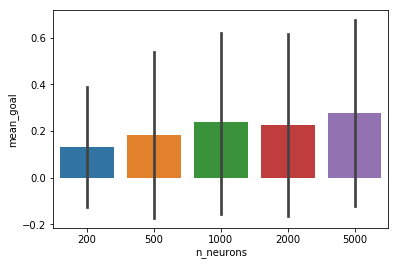

In [6]:
import seaborn
seaborn.barplot('n_neurons', 'mean_goal', data=df)

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


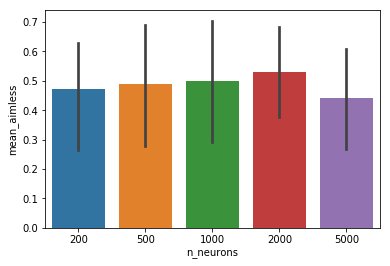

In [7]:
seaborn.barplot('n_neurons', 'mean_aimless', data=df)

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


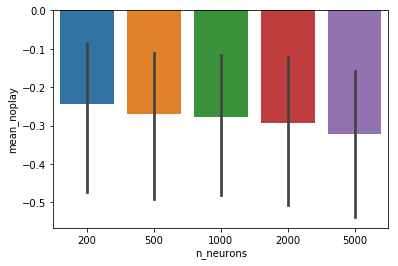

In [8]:
seaborn.barplot('n_neurons', 'mean_noplay', data=df)

In [9]:
for seed in range(5):
    for n_train_pattern in [1,2,3,4,5]:
        PatternInterpolationTrial().run(seed = seed, data_dir='vary_n_train_pattern', 
                                        n_train_pattern = n_train_pattern)

running PatternInterpolationTrial#20190124-203540-f26036eb


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\utils\numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 2000
n_train_pattern = 1
mean_aimless = 0.6919115525653251
mean_goal = 0.42554196448162424
mean_noplay = -0.7012350908137895
median_aimless = 0.49793067744693054
median_goal = 0.5810541561566296
median_noplay = -0.715211554995442
std_aimless = 1.0796530334649448
std_goal = 0.6385115406350633
std_noplay = 0.5464651657882225
running PatternInterpolationTrial#20190124-203605-48135f64


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 2000
n_train_pattern = 2
mean_aimless = 0.7836715618204171
mean_goal = 0.9735380886172377
mean_noplay = -0.21753682418166903
median_aimless = 0.9819838837151227
median_goal = 1.119101929387975
median_noplay = -0.3601196526187976
std_aimless = 0.4712901022878086
std_goal = 0.3690497638124465
std_noplay = 0.5298610502579942
running PatternInterpolationTrial#20190124-203633-54a1ae6a


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 2000
n_train_pattern = 3
mean_aimless = 0.6754345686581064
mean_goal = 0.5353735457420497
mean_noplay = -0.14223104798383981
median_aimless = 0.7797152704067796
median_goal = 0.7237945003670418
median_noplay = -0.45778362614194434
std_aimless = 0.43884282799403174
std_goal = 0.5630150374661671
std_noplay = 0.7506294245350837
running PatternInterpolationTrial#20190124-203701-a14d6d86


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 2000
n_train_pattern = 4
mean_aimless = 0.5324529974363313
mean_goal = 0.3507408698998354
mean_noplay = -0.1836571664467122
median_aimless = 0.5856269297432826
median_goal = 0.5326445343443308
median_noplay = -0.16895357971747604
std_aimless = 0.4987320507355091
std_goal = 0.5106775415926201
std_noplay = 0.28452032107918457
running PatternInterpolationTrial#20190124-203732-3fee2fba


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 0
n_neurons = 2000
n_train_pattern = 5
mean_aimless = 0.4759022980401666
mean_goal = 0.5308950039438102
mean_noplay = 0.43500765284156023
median_aimless = 0.5908505185184691
median_goal = 0.6297766099720863
median_noplay = 0.6637554489050431
std_aimless = 0.38487103887502616
std_goal = 0.3244759150161056
std_noplay = 0.49124014187030635
running PatternInterpolationTrial#20190124-203801-5d315bea


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 2000
n_train_pattern = 1
mean_aimless = 0.4539891880498014
mean_goal = 0.7936044328564602
mean_noplay = -0.796944476393888
median_aimless = 0.008031183143133863
median_goal = 1.0999893801722498
median_noplay = -0.8937862592616765
std_aimless = 1.8285853497990243
std_goal = 0.816949283900324
std_noplay = 0.39744531809031186
running PatternInterpolationTrial#20190124-203823-00e6785d


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 2000
n_train_pattern = 2
mean_aimless = 0.5814481586462095
mean_goal = 0.6435232073511201
mean_noplay = -0.7339026599098218
median_aimless = 0.715669883489323
median_goal = 0.8416825456616291
median_noplay = -0.992170074292924
std_aimless = 0.5890720117215306
std_goal = 0.5695026669590342
std_noplay = 0.4983355054529445
running PatternInterpolationTrial#20190124-203847-89ec065e


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 2000
n_train_pattern = 3
mean_aimless = 0.7486241154369423
mean_goal = -0.3147614652188658
mean_noplay = -0.6901700536734484
median_aimless = 0.8973325807899081
median_goal = -0.39785421036590757
median_noplay = -0.8200218620225067
std_aimless = 0.5367170969870619
std_goal = 0.6415503091605225
std_noplay = 0.4966943247468314
running PatternInterpolationTrial#20190124-203914-99b5565f


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 2000
n_train_pattern = 4
mean_aimless = 0.4757020641148814
mean_goal = -0.5603864534803519
mean_noplay = 0.21455504848167067
median_aimless = 0.5331895763860561
median_goal = -0.48018206300080557
median_noplay = 0.5137024768158585
std_aimless = 0.5249060729717774
std_goal = 0.4428877082904052
std_noplay = 0.6568896819731032
running PatternInterpolationTrial#20190124-203940-3f1c2943


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 1
n_neurons = 2000
n_train_pattern = 5
mean_aimless = 0.4792383519273707
mean_goal = -0.09560701145914845
mean_noplay = 0.4290911961230662
median_aimless = 0.6926050840249489
median_goal = -0.16310795808539202
median_noplay = 0.6768112628236574
std_aimless = 0.5276540201034943
std_goal = 0.41266465633989663
std_noplay = 0.5132066559191015
running PatternInterpolationTrial#20190124-204009-46db6167


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
n_neurons = 2000
n_train_pattern = 1
mean_aimless = 0.7606551431578557
mean_goal = 0.820828908174358
mean_noplay = -0.8791227406219735
median_aimless = 1.0096433862063663
median_goal = 1.00171723699339
median_noplay = -0.9988008346495465
std_aimless = 0.5160276499955532
std_goal = 0.34430953445985213
std_noplay = 0.3569345063498081
running PatternInterpolationTrial#20190124-204029-cd033e81


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
n_neurons = 2000
n_train_pattern = 2
mean_aimless = 0.6294776305150465
mean_goal = 0.6506928082180329
mean_noplay = 0.47026584173567426
median_aimless = 0.9261910440145458
median_goal = 0.7715113614371217
median_noplay = 0.45423946359160894
std_aimless = 0.6136797463814406
std_goal = 0.3377044645271569
std_noplay = 0.20887459009438822
running PatternInterpolationTrial#20190124-204052-78617a4c


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
n_neurons = 2000
n_train_pattern = 3
mean_aimless = 0.5044152521279898
mean_goal = 0.5111338629379788
mean_noplay = -0.11021665211871136
median_aimless = 0.9021603095122507
median_goal = 0.7676148844557773
median_noplay = -0.5383294990634683
std_aimless = 1.027340125080931
std_goal = 0.5225532661878124
std_noplay = 0.7705986845362466
running PatternInterpolationTrial#20190124-204120-ca02bfa3


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
n_neurons = 2000
n_train_pattern = 4
mean_aimless = 0.47486145773959626
mean_goal = 0.7984836252729183
mean_noplay = 0.3067987678576608
median_aimless = 0.6564932485105448
median_goal = 0.8197224597404225
median_noplay = 0.4499336983006236
std_aimless = 0.5023825370935732
std_goal = 0.23504598122477696
std_noplay = 0.56203168862214
running PatternInterpolationTrial#20190124-204147-9844688d


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 2
n_neurons = 2000
n_train_pattern = 5
mean_aimless = 0.547058072021402
mean_goal = 0.8053111549659826
mean_noplay = -0.056948727898235844
median_aimless = 0.6696456633832307
median_goal = 0.8317946206346448
median_noplay = -0.3112674013047325
std_aimless = 0.41639141792740814
std_goal = 0.17684701513813392
std_noplay = 0.7154635760426312
running PatternInterpolationTrial#20190124-204213-4ccd19ef


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
n_neurons = 2000
n_train_pattern = 1
mean_aimless = 0.38475003534391794
mean_goal = 0.6502919884401469
mean_noplay = -0.862787329303526
median_aimless = 0.13753988049633475
median_goal = 0.721310475395822
median_noplay = -0.9959160377019669
std_aimless = 1.7980636998924113
std_goal = 0.8492978763735556
std_noplay = 0.4432083872433164
running PatternInterpolationTrial#20190124-204233-27215708


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
n_neurons = 2000
n_train_pattern = 2
mean_aimless = -0.47425177731652446
mean_goal = -0.10437041166526341
mean_noplay = -0.9080746342490019
median_aimless = -0.901240270866788
median_goal = -0.13529228160123696
median_noplay = -0.9479275611994078
std_aimless = 0.8549844454946344
std_goal = 0.315266255158152
std_noplay = 0.2501283639729424
running PatternInterpolationTrial#20190124-204306-5018f796


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
n_neurons = 2000
n_train_pattern = 3
mean_aimless = 0.23667854059646473
mean_goal = -0.36190143450233064
mean_noplay = -0.38288764408333836
median_aimless = 0.33496255489249627
median_goal = -0.4379602476185342
median_noplay = -0.3850077384359891
std_aimless = 0.5693447676020834
std_goal = 0.5322869749797351
std_noplay = 0.36303390363714344
running PatternInterpolationTrial#20190124-204333-de3ab20f


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
n_neurons = 2000
n_train_pattern = 4
mean_aimless = 0.34102440694748093
mean_goal = -0.020013589288876858
mean_noplay = 0.028387267033650715
median_aimless = 0.46003605978870976
median_goal = 0.022693004145137276
median_noplay = 0.12367022966215166
std_aimless = 0.3651153251504748
std_goal = 0.45636655752140926
std_noplay = 0.38860890773025997
running PatternInterpolationTrial#20190124-204359-e880c48e


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 3
n_neurons = 2000
n_train_pattern = 5
mean_aimless = 0.48736808124734954
mean_goal = -0.05123601559556261
mean_noplay = 0.17448507178554964
median_aimless = 0.6717038996246408
median_goal = -0.09675988705759622
median_noplay = 0.2936725164555435
std_aimless = 0.4543300555663381
std_goal = 0.46295024208652485
std_noplay = 0.48470812467670354
running PatternInterpolationTrial#20190124-204427-27b36e7c


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
n_neurons = 2000
n_train_pattern = 1
mean_aimless = 0.4009095804551247
mean_goal = 0.6314232403134868
mean_noplay = -0.8600520178644492
median_aimless = 0.34059031071827806
median_goal = 0.9137521288109607
median_noplay = -1.0164848943520877
std_aimless = 0.7556205960768688
std_goal = 0.5167790966937637
std_noplay = 0.2763748889981276
running PatternInterpolationTrial#20190124-204451-e4c766b0


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
n_neurons = 2000
n_train_pattern = 2
mean_aimless = 0.3601321114227341
mean_goal = 0.7061131965280003
mean_noplay = -0.6321245968535603
median_aimless = 0.18671999519663934
median_goal = 0.7131655278742128
median_noplay = -0.941683177453239
std_aimless = 0.8731132596635771
std_goal = 0.4843558907712798
std_noplay = 0.6866076418080573
running PatternInterpolationTrial#20190124-204514-7c10ae88


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
n_neurons = 2000
n_train_pattern = 3
mean_aimless = 0.4865865604721169
mean_goal = 0.752917970927863
mean_noplay = -0.13578720570572025
median_aimless = 0.3429796076224486
median_goal = 0.7501965247332889
median_noplay = -0.1813105388957148
std_aimless = 0.9435682559704208
std_goal = 0.5217687593154509
std_noplay = 0.4707961996203384
running PatternInterpolationTrial#20190124-204537-3c95ce32


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
n_neurons = 2000
n_train_pattern = 4
mean_aimless = 0.5812721799335145
mean_goal = -0.02647344467824053
mean_noplay = 0.3618335694168583
median_aimless = 0.7059123001282858
median_goal = 0.011791935597851015
median_noplay = 0.6990053218110748
std_aimless = 0.4290031839968213
std_goal = 0.5700658995908611
std_noplay = 0.6958600820301833
running PatternInterpolationTrial#20190124-204601-fec9d47d


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)
C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

seed = 4
n_neurons = 2000
n_train_pattern = 5
mean_aimless = 0.5106415513200802
mean_goal = -0.14451990527181074
mean_noplay = 0.36433929390891573
median_aimless = 0.7044137727596791
median_goal = -0.17259301715945005
median_noplay = 0.48033726856198716
std_aimless = 0.5128637329752648
std_goal = 0.4523228479352664
std_noplay = 0.5104182347501999


In [10]:
import pandas
df = pandas.DataFrame(pytry.read('vary_n_train_pattern'))
df

,mean_aimless,mean_goal,mean_noplay,median_aimless,median_goal,median_noplay,n_neurons,n_train_pattern,seed,std_aimless,std_goal,std_noplay
0,0.691912,0.425542,-0.701235,0.497931,0.581054,-0.715212,2000,1,0,1.079653,0.638512,0.546465
1,0.783672,0.973538,-0.217537,0.981984,1.119102,-0.360120,2000,2,0,0.471290,0.369050,0.529861
2,0.675435,0.535374,-0.142231,0.779715,0.723795,-0.457784,2000,3,0,0.438843,0.563015,0.750629
3,0.532453,0.350741,-0.183657,0.585627,0.532645,-0.168954,2000,4,0,0.498732,0.510678,0.284520
4,0.475902,0.530895,0.435008,0.590851,0.629777,0.663755,2000,5,0,0.384871,0.324476,0.491240
5,0.453989,0.793604,-0.796944,0.008031,1.099989,-0.893786,2000,1,1,1.828585,0.816949,0.397445
6,0.581448,0.643523,-0.733903,0.715670,0.841683,-0.992170,2000,2,1,0.589072,0.569503,0.498336
7,0.748624,-0.314761,-0.690170,0.897333,-0.397854,-0.820022,2000,3,1,0.536717,0.641550,0.496694
8,0.475702,-0.560386,0.214555,0.533190,-0.480182,0.513702,2000,4,1,0.524906,0.442888,0.656890
9,0.479238,-0.095607,0.429091,0.692605,-0.163108,0.676811,2000,5,1,0.527654,0.412665,0.513207


C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


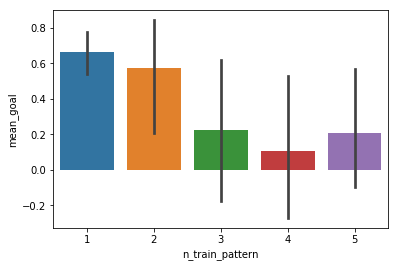

In [11]:
seaborn.barplot('n_train_pattern', 'mean_goal', data=df)

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


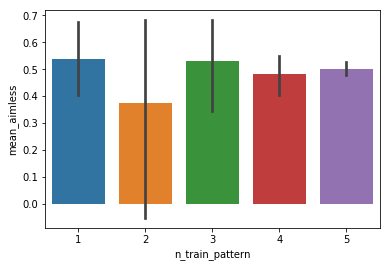

In [12]:
seaborn.barplot('n_train_pattern', 'mean_aimless', data=df)

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


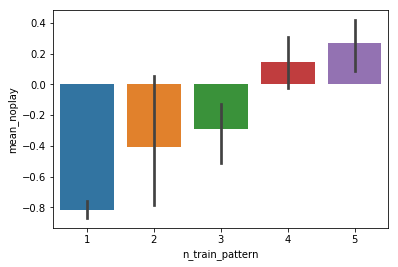

In [13]:
seaborn.barplot('n_train_pattern', 'mean_noplay', data=df)

In [14]:
#df

In [15]:
#import seaborn

#seaborn.barplot('n_neurons', 'mean_aimless', data=df)